# **Advanced Techniques in Data Analysis - MACHINE LEARNING PROJECT** 

## Objectives and Motivation

In this project we want to make a deep dive into the world of stock prediction, more specifically on the PayPal stock. Our objectives are:

- Make a rigorous time series analysis to define our approach

- Make a classifier to evaluate if the stock will go up or down 





# Importing the Paypal Stock information

## Imports and Data Cleaning

In [4]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, precision_score, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import LinearSVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

# SciPy
from scipy.stats import norm, shapiro, skew, kurtosis

# Matplotlib Helpers
from matplotlib.patches import Patch

# Configuração (mantida no topo/fim, dependendo da preferência)
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'torch'

Now we download the Standard & Poor 500 dataset (or keep it updated)

In [4]:
import kagglehub


path = kagglehub.dataset_download("yash16jr/s-and-p500-daily-update-dataset")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:03<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/317


In [5]:
from pathlib import Path

# Use a raw string for the Windows path to avoid escaping issues
path = Path(r"/Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/314")

print("Path to dataset files:", path)

if path.exists():
    for p in sorted(path.iterdir()):
        print(p.name)
else:
    print(f"Path not found: {path}. Please run the download cell or verify the path.")


Path to dataset files: /Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/314
SnP_daily_update.csv


In [6]:
from pathlib import Path

# Explicitly point to the S&P CSV in your kagglehub cache (Windows path)
csv_path = Path(r"/Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/314/SnP_daily_update.csv")

if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found at {csv_path}. Please verify the path or run the download cell first.")

print('Loading CSV from:', csv_path)

df = pd.read_csv(str(csv_path), header=[0, 1], index_col=0, parse_dates=True)

print(df.head())


Loading CSV from: /Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/314/SnP_daily_update.csv
Price           Close                                                      \
Ticker              A      AAPL ABBV ABNB        ABT      ACGL        ACN   
Date                                                                        
2010-01-04  19.891684  6.418384  NaN  NaN  18.414791  7.601905  31.492186   
2010-01-05  19.675606  6.429477  NaN  NaN  18.266006  7.576549  31.686808   
2010-01-06  19.605694  6.327211  NaN  NaN  18.367449  7.543795  32.023666   
2010-01-07  19.580271  6.315512  NaN  NaN  18.519604  7.499420  31.993708   
2010-01-08  19.573912  6.357500  NaN  NaN  18.614283  7.484628  31.866470   

Price                                        ...   Volume                    \
Ticker           ADBE        ADI        ADM  ...       WY     WYNN      XEL   
Date                                         ...                              
2010-

In [7]:
df_pypl_completo = df.xs('PYPL', level=1, axis=1)

In [8]:
df_pypl_completo.columns = [col.lower() for col in df_pypl_completo.columns]

if 'price' in df_pypl_completo.columns:
    df_pypl_completo = df_pypl_completo.drop(columns=['price'])

df_pypl_completo.dropna(subset=['close'], inplace=True)

df_pypl = df_pypl_completo.copy()

print("PayPal's DataFrame (PYPL) Clean and Ready:")
print(df_pypl.head())
print(f"Column number: {df_pypl.shape[1]}")
print(f"Existent Columns: {list(df_pypl.columns)}")


PayPal's DataFrame (PYPL) Clean and Ready:
                close       high        low       open     volume
Date                                                             
2015-07-06  36.625332  39.658321  35.916970  37.912358  5866600.0
2015-07-07  36.535538  37.722796  35.916969  37.633003  7359000.0
2015-07-08  34.619968  36.276140  34.450359  36.256185  5387700.0
2015-07-09  34.420429  35.438077  33.911607  35.019044  3760100.0
2015-07-10  34.609989  35.108836  33.901628  34.580060  4472800.0
Column number: 5
Existent Columns: ['close', 'high', 'low', 'open', 'volume']


# Time Series Analysis


Stock market predicition must be preceded by a rigorous Time Series Analysis. Financial data is unique because observations are not independent and identifcally distributed, they exibit autocorrelation and non-stationarity.


Time Series Analysis serves two critical functions:

- Risk Management: Quantifying extreme events. This will provide context for interpreting machine learning models.

- Validation and feature engineering: It allow us to confirm the statistical properties of data (Stationarity and other)

## Discrete Analysis

# Stationarity Tests (ADF + KPSS)

We apply two complementary stationarity tests:

- **Augmented Dickey–Fuller (ADF)**: null hypothesis = *unit root (non-stationary)*. A small p-value (e.g. < 0.05) means we reject the null and conclude the series is stationary.
- **KPSS**: null hypothesis = *stationary*. A small p-value means we reject the null and conclude the series is non-stationary.

Using both tests together helps avoid mistaken conclusions. The code cell that follows runs both tests, plots rolling mean/std, and shows how to difference a series if non‑stationary.

In [2]:
def test_stationarity(series, name=None, regression='c', signif=0.05, plot=True, window=30):
    """Run ADF and KPSS on a series and print results.
    - series: pd.Series
    - regression: 'c' (constant) or 'ct' (constant+trend) for KPSS
    """
    s = series.dropna()
    if name is None:
        name = getattr(series, 'name', 'series')
    print(f"=== Stationarity test for: {name} ===")

    
    try:
        adf_res = adfuller(s, autolag='AIC')
        print('\nADF test:')
        print(f'  ADF statistic : {adf_res[0]:.4f}')
        print(f'  p-value        : {adf_res[1]:.4f}')
        for k, v in adf_res[4].items():
            print(f'    critical {k}: {v:.4f}')
        if adf_res[1] < signif:
            print('  -> Reject H0: series is likely STATIONARY (ADF)')
        else:
            print('  -> Fail to reject H0: series is likely NON-STATIONARY (ADF)')
    except Exception as e:
        print('  ADF failed:', e)

   
    try:
        kpss_res = kpss(s, regression=regression, nlags='auto')
        print('\nKPSS test:')
        print(f'  KPSS statistic: {kpss_res[0]:.4f}')
        print(f'  p-value       : {kpss_res[1]:.4f}')
        for k, v in kpss_res[3].items():
            print(f'    critical {k}: {v:.4f}')
        if kpss_res[1] < signif:
            print('  -> Reject H0: series is likely NON-STATIONARY (KPSS)')
        else:
            print('  -> Fail to reject H0: series is likely STATIONARY (KPSS)')
    except Exception as e:
        print('  KPSS failed:', e)

    
    if plot:
        plt.figure(figsize=(10, 4))
        rolling_mean = s.rolling(window=window).mean()
        rolling_std = s.rolling(window=window).std()
        plt.plot(s.index, s, label=name, alpha=0.6)
        plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling mean ({window})')
        plt.plot(rolling_std.index, rolling_std, label=f'Rolling std ({window})')
        plt.legend()
        plt.title(f'Rolling statistics: {name}')
        plt.show()

    print('\nInterpretation guidelines:')
    print('  - ADF small p-value & KPSS large p-value => STATIONARY')
    print('  - ADF large p-value & KPSS small p-value => NON-STATIONARY')
    print('  - If both tests disagree, inspect plots and consider differencing or detrending.')
    print('\n')


Testing for the returns and log returns will conclude our preposition:

In [3]:
try:
    test_stationarity(df_pypl['close'], name='close (level)', regression='ct')
except Exception as e:
    print('close test skipped (df_pypl missing?):', e)

# 2) Returns (usually stationary after removing mean)
try:
    test_stationarity(df_analysis["log_ret"], name='Log Returns', regression='c')
except Exception as e:
    print('returns test skipped:', e)



# If a series is non-stationary, show how to difference and re-test:
def difference_and_test(series, name=None, d=1):
    s = series.dropna()
    for i in range(d):
        s = s.diff().dropna()
    new_name = f"{name} (diff^{d})" if name else f"diff^{d}"
    test_stationarity(s, name=new_name)

# Example: if 'close' non-stationary, test first difference
try:
    print('--- If close non-stationary, testing first difference: ---')
    difference_and_test(df_pypl['close'], name='close', d=1)
except Exception:
    pass

close test skipped (df_pypl missing?): name 'df_pypl' is not defined
returns test skipped: name 'df_analysis' is not defined
--- If close non-stationary, testing first difference: ---


## Logarithmic Return 

Log returns have the special property of sum. Normal Returns need Stochastic math

In [9]:
df_pypl["log_ret"]= np.log(df_pypl["close"] / df_pypl["close"].shift(1))
df_analysis = df_pypl.dropna()

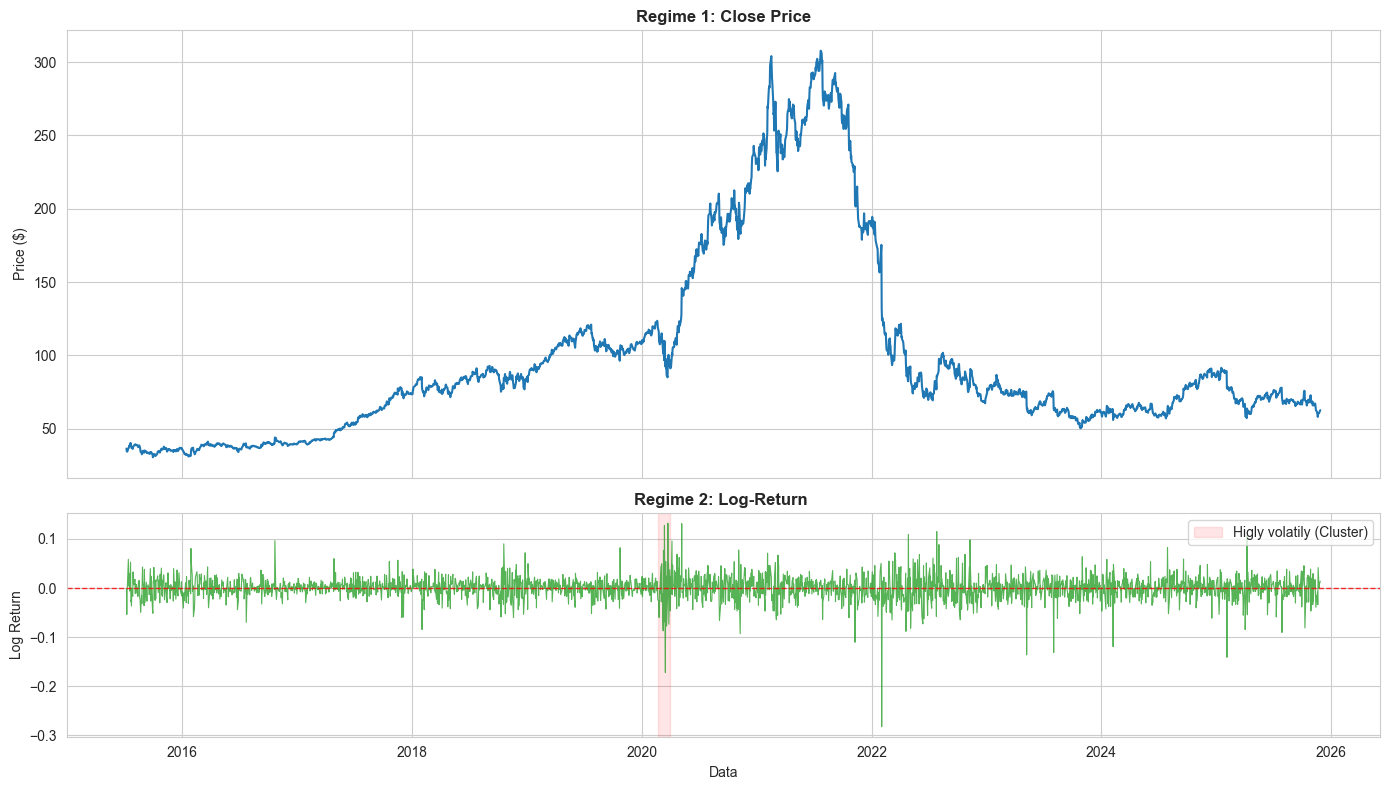

In [10]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,1,figsize=(14,8), sharex=True, gridspec_kw={"height_ratios": [2,1]})

ax[0].plot(df_analysis.index, df_analysis['close'], color='#1f77b4', linewidth=1.5)
ax[0].set_title('Regime 1: Close Price', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Price ($)', fontsize=10)
ax[0].margins(x=0) # Remove margens brancas laterais


ax[1].plot(df_analysis.index, df_analysis['log_ret'], color='#2ca02c', linewidth=0.8, alpha=0.8)
ax[1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.8) # A linha da média zero
ax[1].set_title('Regime 2: Log-Return ', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Log Return', fontsize=10)
ax[1].set_xlabel('Data', fontsize=10)


covid_start = '2020-02-20'
covid_end = '2020-04-01'
ax[1].axvspan(covid_start, covid_end, color='red', alpha=0.1, label='Higly volatily (Cluster)')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Histogram of log returns

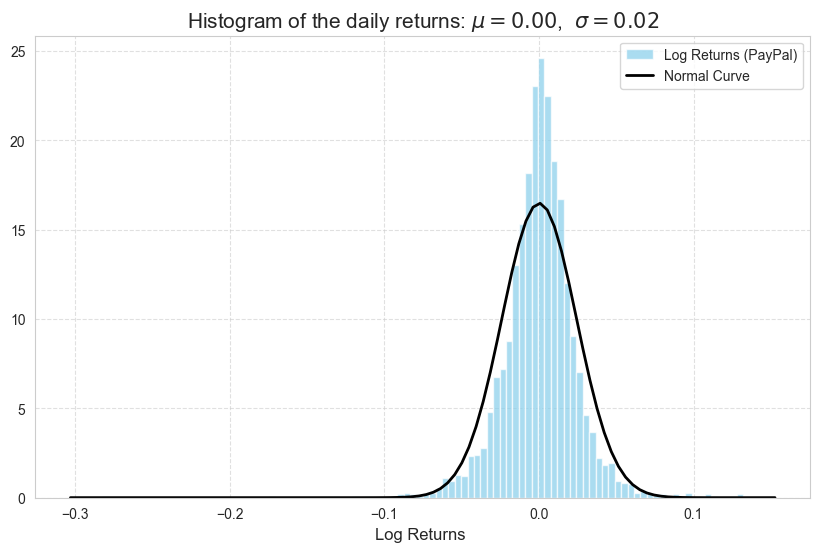

In [11]:

plt.figure(figsize=(10,6))
plt.hist(df_analysis["log_ret"], bins=100, density = True, label = "Log Returns (PayPal)", color = "skyblue", alpha=0.7)

from scipy.stats import norm

mu, sigma = df_analysis["log_ret"].mean(), df_analysis["log_ret"].std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma) 


plt.plot(x, p, 'k', linewidth=2, label='Normal Curve')


title = "Histogram of the daily returns: $\mu = %.2f$,  $\sigma = %.2f$" % (mu, sigma)
plt.title(title, fontsize=15)
plt.xlabel("Log Returns ", fontsize=12)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
shapiro_result = shapiro(df_analysis["log_ret"])

alpha = 0.05

print(f"Shapiro-Wilk Statistics: {shapiro_result[0]:.4f}")
print(f"P-value: {shapiro_result[1]:.4f}")

# Test Null Hypothesis
if shapiro_result[1] <= alpha:
    print("Conclusion: Null hypothesis of the Shapiro-Wilk test (the population is normally distributed) is rejected.")
else:
    print("Conclusion: The null hypothesis of the Shapiro-Wilk test can't be rejected.")

Since it's proven that this dataset is not normally distributed (being a $t$-student distribution), we should evaluate the skewness and the kurtosis. 

In [ ]:
kurtosis_value = kurtosis(df_analysis["log_ret"], fisher=False) 

skewness_value = skew(df_analysis["log_ret"])

print(f"Skewness: {skewness_value:.4f}")
print(f"Kurtosis: {kurtosis_value:.4f}")

The analysis of PayPal stock returns shows negative skewness, indicating that the left tail of the distribution is longer and extreme negative returns occur more frequently than extreme positive ones. Additionally, the very high kurtosis points to the presence of many extreme values overall.

In combination, negative skewness and high kurtosis suggest that the returns are prone to significant downside risk: while extreme events can occur on both sides, a substantial portion is likely to be large losses. This indicates that traditional risk models assuming normality may underestimate the probability and magnitude of extreme losses, justifying the use of advanced risk models capable of capturing fat tails and asymmetry in financial returns, such as GARCH using $t$-distributions.

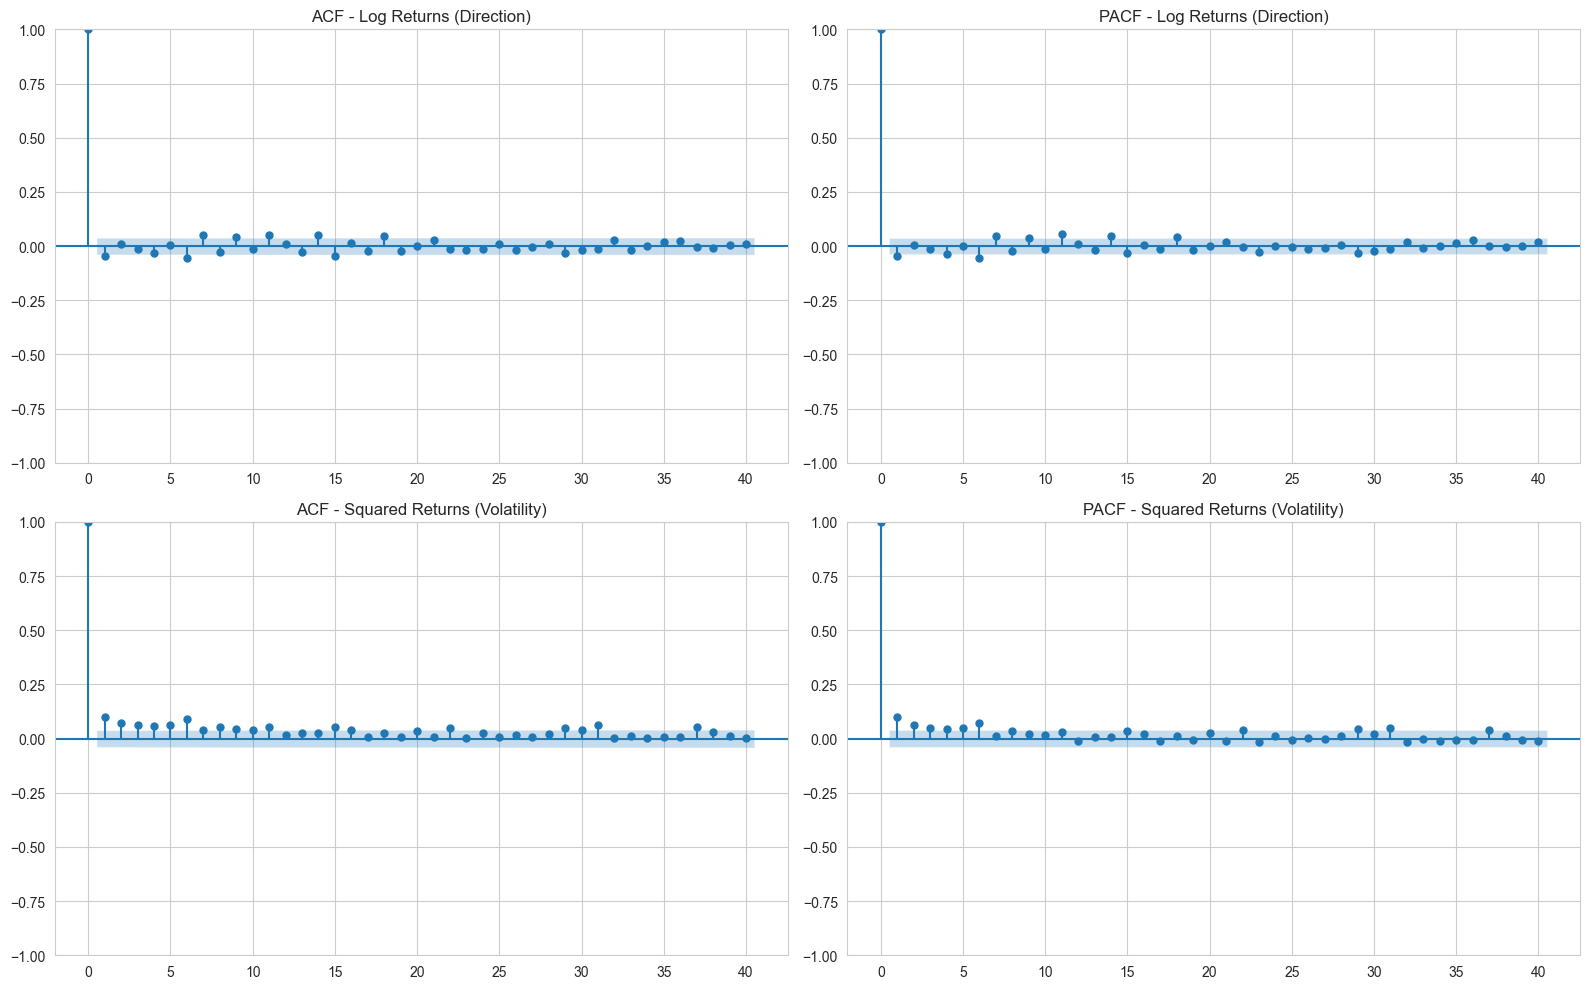

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configurar a área de plotagem (2 linhas, 2 colunas)
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# --- LINHA 1: Log-Retornos (Direção) ---
# Verifica se o retorno de hoje prevê o de amanhã (Linearmente)
plot_acf(df_analysis['log_ret'], lags=40, ax=ax[0, 0], title='ACF - Log Returns (Direction)')
plot_pacf(df_analysis['log_ret'], lags=40, ax=ax[0, 1], title='PACF - Log Returns (Direction)')

# --- LINHA 2: Log-Retornos ao Quadrado (Volatilidade/Risco) ---
# Verifica se a magnitude (risco) de hoje prevê a de amanhã
plot_acf(df_analysis['log_ret']**2, lags=40, ax=ax[1, 0], title='ACF - Squared Returns (Volatility)')
plot_pacf(df_analysis['log_ret']**2, lags=40, ax=ax[1, 1], title='PACF - Squared Returns (Volatility)')

plt.tight_layout()
plt.show()

We observed that the autocorrelation is practically zero in every lag on Log Returns -> this means that there is no linear correlation between the return of today and yesterday. Despite this we can see that the volatility (Returns squared) have a positive magnitude -> this shows that using volatility as a feature will show hidden signals and will improve our machine learning model.

### Conclusion

- Non-stationary features are basically random walks, there is too much noise into the feature and there is no apparent trend. The use of Log-Returns guarantees the stability of the training model.

- Since the log returns does not show normality, we need to to exclude simple linear models and we need advanced models such as LSTMs and GARCH. Only those will guarantee the detection of non-linear dynamics.

# Feature Engineering

As we saw in the Time Series Analysis section we should implement features that are stationary, there are 4 types of analytical features in this context:

- Momentum & trend

- Volatility

- Volume & Liquidity



## Momentum & Trend

### Relative Strength Index (RSI)
RSI is an indicator of momentum which measures the magnitude of the recent changes in price

In [17]:
def add_rsi_feature(df, window =14):
    df=df.copy()
    delta = df["close"].diff()

    gain=delta.where(delta > 0, 0)
    loss = -delta.where(delta <0,0)

    avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    rs = avg_gain / avg_loss
    df["RSI"]= 100 - (100 / (1+ rs))
    df["RSI_Norm"]= df["RSI"] / 100

    return df.dropna()

### Moving Average Convergence Divergence

MACD illustrates the relatioship between two moving averages of a security's price. (Acceleration)

In [18]:
def add_macd_feature(df):
    df = df.copy()
    
    k_fast = 12
    k_slow = 26
    k_signal = 9
    
    ema_fast = df['close'].ewm(span=k_fast, adjust=False).mean()
    ema_slow = df['close'].ewm(span=k_slow, adjust=False).mean()
    
    
    macd_line = ema_fast - ema_slow
    
    
    signal_line = macd_line.ewm(span=k_signal, adjust=False).mean()
    
    
    macd_hist = macd_line - signal_line
    
    df['MACD_Norm'] = macd_hist / df['close']
    
    return df.dropna()

### Distance to Simple Moving Average

Moving averages in general are not stationary, using a distance between those moving averages will set the stationarity

In [19]:
def add_sma_distance_feature(df, window=50):
    df = df.copy()
    sma = df['close'].rolling(window=window).mean()
    df[f'Dist_SMA{window}'] = (df['close'] / sma) - 1
    
    return df.dropna()

## Volatility

We will give to the model 3 types of volatility metrics:
- The Realized Volatility
- The relative Volatility
- The conditional volatility (which is so extense that it got its own section)

### Realized Volatility

Realized Volatility is the volatility that actually happened before:

$$ \sigma_\text{realized}=\sqrt{\frac{1}{N-1}\sum_{i=1}^N (r_{t-i}-r)^2}$$

In [20]:
def add_realized_volatility(df, window=20):
    df = df.copy()
    
    if 'log_ret' not in df.columns:
        df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    df['Vol_Realized'] = df['log_ret'].rolling(window=window).std()
    df.dropna(inplace=True)
    
    return df

### Bollinger Band Width

This relative volatility is based on the theory of Volatility Squeeze: Periods of extreme calmness tends to accumulate pression and then release in explosive movements (high volatility).

In [21]:
def add_bb_width(df, window=20, k=2):
    df = df.copy()
    
    # 1. Componentes das Bandas
    sma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    
    # 2. Cálculo Direto da Largura Normalizada
    # (Upper - Lower) / Middle  == (4 * std) / sma
    df['BB_Width'] = (4 * k * std) / sma
    
    return df.dropna()

## Volume & Liquidity

### Log Volume Change

In [22]:
def add_log_vol_change(df):
    df = df.copy()
    df['Log_Vol_Change'] = np.log(df['volume'] / df['volume'].shift(1).replace(0, 1))
    
    return df.dropna()

### Relative Volume

In [23]:
def add_rvol_feature(df, window=20):
    df = df.copy()
    
    # Calcular a média móvel do volume (o "Normal")
    vol_mean = df['volume'].rolling(window=window).mean()
    
    # Calcular o Rácio
    # Adicionamos 1 no denominador apenas para segurança (evitar div por 0), 
    # mas num ativo líquido como PYPL não é estritamente necessário.
    df['RVOL'] = df['volume'] / vol_mean
    
    return df.dropna()

## Target

Since we want to predict if the price is higher or lower we have to define:

In [24]:
df_pypl["Target"]= (df_pypl["log_ret"].shift(-1)>0).astype(int) 


# Risk Management on PayPal Stocks

Risk Management is fundamental to predict the behavior of stocks. Markowitz stated in his famous book, that volatility, which was a phenomenon not closely linked to math, to be the standard deviation of returns, $\sigma_r$.

There are Several methods to predict volatility, we will start with 2 classical ones and then move to a machine learning approach, with support vector regressors and neural networks. 

But first we will calculate the return volatility by using the formula for the Realized Volatility:

$$ \sigma=\sqrt{\frac{1}{n-1}\sum_{n=1}^N (r_n -\mu_r)^2} $$

where $N$ is the number of observations, $r_n$ is the return at observation $n$ and $\mu_r$ is the average return

In [25]:
ret = 100 * (df_pypl['close'].pct_change()).dropna()
realized_vol = ret.rolling(5).std()

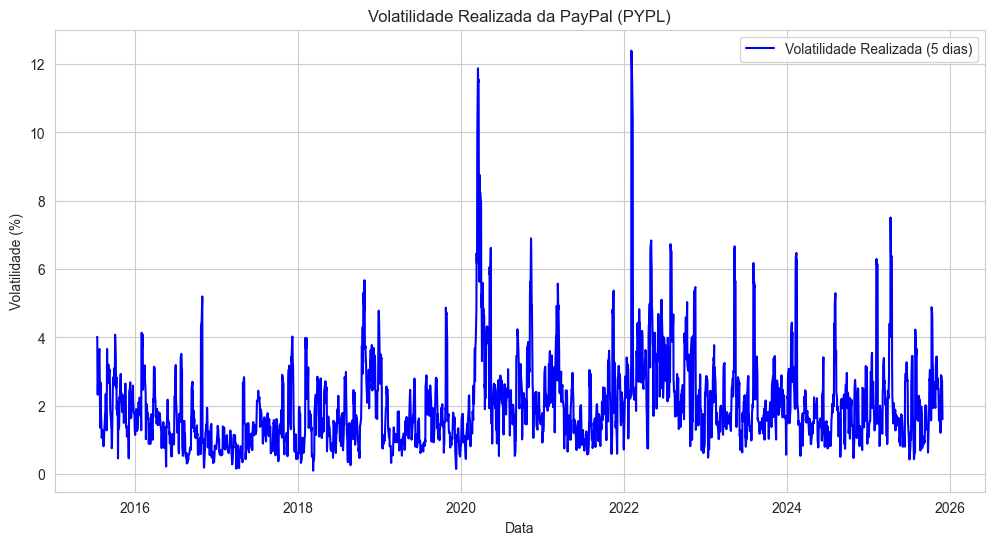

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label='Volatilidade Realizada (5 dias)', color='blue')
plt.title('Volatilidade Realizada da PayPal (PYPL)')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.legend()
plt.show()

This is interesting because we can see big spikes on 2020 and 2022:

- 2020: Begining of the COVID pandemic

- 2022: A shocking report about the Q4 2021 was released. The sharp drop was due to the company drastically cutting its growth forecasts.

In [27]:
retv = ret.values

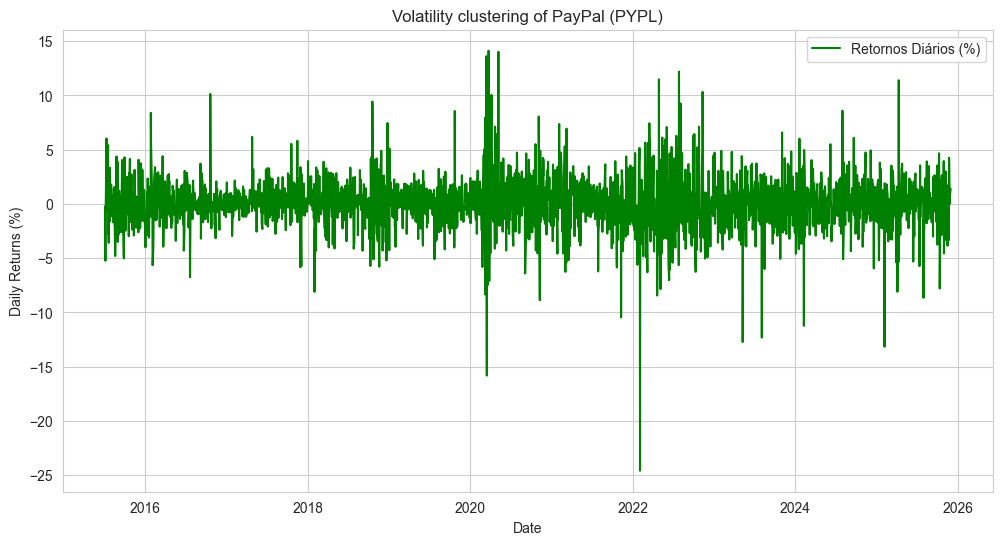

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(df_pypl.index[1:], retv, label='Retornos Diários (%)', color='green')
plt.title('Volatility clustering of PayPal (PYPL)')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.legend()
plt.show()

with this volatility clustering we can now in which direction was the spikes on 2020 and 2022 (downwards)

## ARCH Model

The ARCH model was one of the first statistical models introduced to predict volatility: the ARCH model is a univariate model and based on historical asset returns

$$\sigma_t ^2 = \omega + \sum_{k=1}^p \alpha_k (r_{t - k})^2$$

where the mean model is:

$$ r_t = \sigma_t \epsilon_t $$

where $\epsilon_t$ is assumed to be normally distributed

In this project we will not implement the ARCH model from the ground, instead we will use the arch library

In [29]:
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse

In [30]:
arch = arch_model(ret, mean="Zero", vol="ARCH", p=1).fit(disp="off")
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5953.92
Distribution:                  Normal   AIC:                           11911.8
Method:            Maximum Likelihood   BIC:                           11923.6
                                        No. Observations:                 2617
Date:                Tue, Dec 09 2025   Df Residuals:                     2617
Time:                        15:43:18   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          4.7269      0.330     14.325  1.531e-46   [  4.08

In [31]:
n=200
split_date=ret.iloc[-n:].index


In [32]:
bic_arch = []
for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())

forecast_arch = arch.forecast(start=split_date[0])


                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5843.26
Distribution:                  Normal   AIC:                           11696.5
Method:            Maximum Likelihood   BIC:                           11725.9
                                        No. Observations:                 2617
Date:                Tue, Dec 09 2025   Df Residuals:                     2617
Time:                        15:43:18   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          2.8100      0.325      8.646  5.327e-18    [  

In [33]:
rmse_arch=np.sqrt(mse(realized_vol[-n:] /100 , np.sqrt(forecast_arch.variance.iloc[-len(split_date): ] /100 )))
print(f"RMSE for ARCH model: {rmse_arch}")

RMSE for ARCH model: 0.22254003730245864


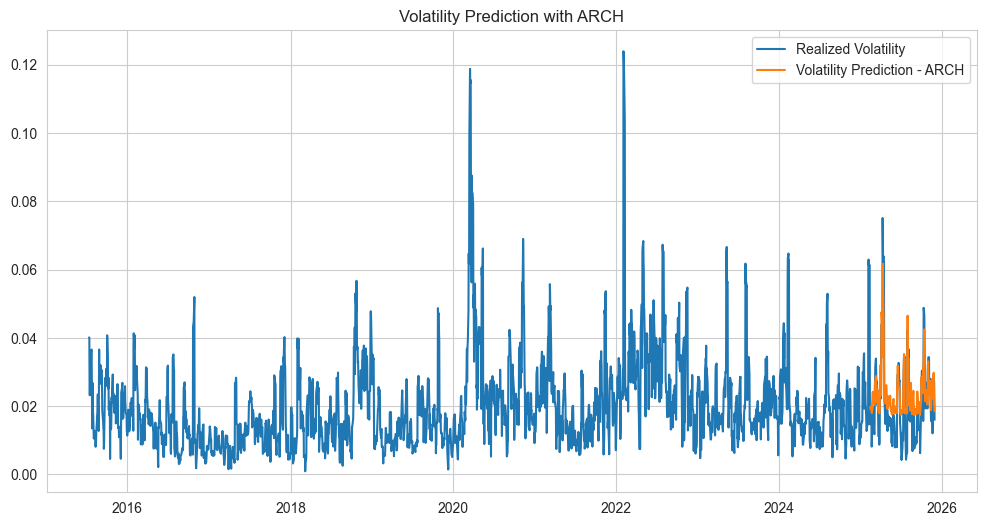

In [34]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol /100 , label= "Realized Volatility")
plt.plot(np.sqrt(forecast_arch.variance.iloc[-len(split_date):]) /100 , label = "Volatility Prediction - ARCH")
plt.title("Volatility Prediction with ARCH", fontsize = 12)
plt.legend()
plt.show()

As we can see we got a nice prediction of the volatility, even using an old model such as ARCH.

Disadvantages of using ARCH:
- Needs a lot of parameters: Markets are complex, and ARCH model can not capture all the shocks of volatility in data using a small $p$. To get a good modelation, a higher $p$ would be necessary

- Non-negativity: Two of the assumptions of ARCH are that $\alpha_k$ and $\omega$ are $>0$ which turns the volatility hard to model.

- Information assimetry: ARCH only looks for past returns, $r_{t-k} ^2$ to predict future volatility, $\sigma_t ^2$, but ignores the direction of the shock. This means that the model cannot capture the leverage effect: Bad news tend to a higher volatility and good news tends to lower volatility.

## GARCH model

GARCH is an extension of ARCH incorporating lagged conditional variance. This makes the model multivariate in the sense that it is an autoregressive moving average model.

In [35]:
bic_garc= []

for p in range (1,5):
    for q in range(1,5):
        garch = arch_model(ret, mean="zero", vol="GARCH", p=p, o=0, q=q).fit(disp="off")
        bic_garc.append(garch.bic)
        if garch.bic == np.min(bic_garc):
            best_param = (p,q)
garch = arch_model(ret, mean="zero", vol="GARCH", p=best_param[0], o=0, q=best_param[1]).fit(disp="off")
print(garch.summary())
forecast_garch = garch.forecast(start=split_date[0])
forecast_garch 

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5801.14
Distribution:                  Normal   AIC:                           11608.3
Method:            Maximum Likelihood   BIC:                           11625.9
                                        No. Observations:                 2617
Date:                Tue, Dec 09 2025   Df Residuals:                     2617
Time:                        15:43:19   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2366      0.118      2.011  4.434e-02 [5.984e-0

In [36]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] /100 , np.sqrt(forecast_garch.variance.iloc[-len(split_date): ]  )))/100
print(f"RMSE for GARCH model: {rmse_garch}")

RMSE for GARCH model: 0.02423618876445342


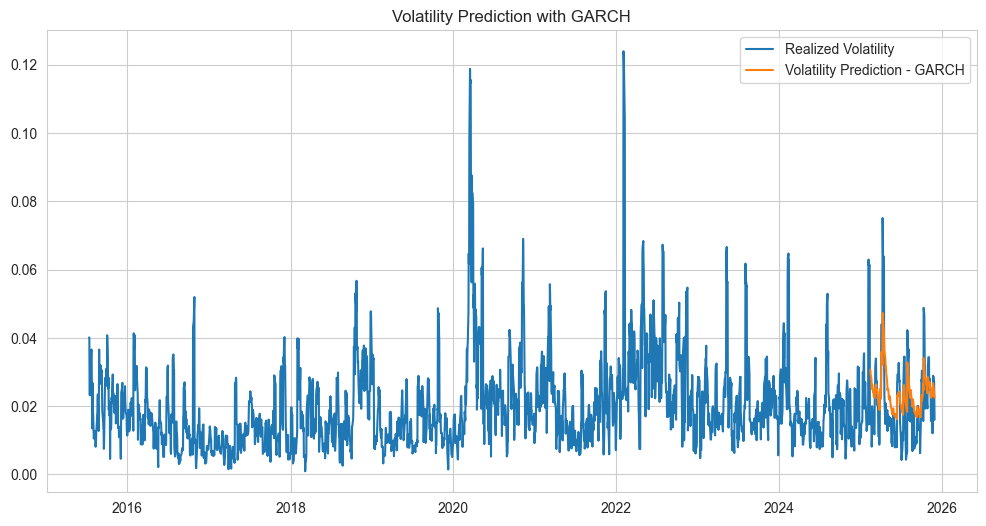

In [37]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol /100 , label= "Realized Volatility")
plt.plot(np.sqrt(forecast_garch.variance.iloc[-len(split_date):]) /100 , label = "Volatility Prediction - GARCH")
plt.title("Volatility Prediction with GARCH", fontsize = 12)
plt.legend()
plt.show()

We can see that GARCH got a slight better value than ARCH, but still a bad value.

## Support Vector Regression with GARCH

In this section we complement the volatility estimates generated by the GARCH model with Support Vector Regression (SVR).. The goal is to allow a non-linear model to learn additional patterns that GARCH cannot capture. SVR is particularly suitable for financial volatility because it can model complex relationships while remaining robust to noise, a common characteristic of financial time series.

### Theoretical Background and Mechanism of SVR

Support Vector Regression (SVR) is an extension of Support Vector Machines (SVM) for regression tasks.  
SVR tries to find a function \(f(x) = w^T \phi(x) + b\) that approximates the target \(y\) with a maximum deviation of \(\epsilon\).  

It solves the following optimization problem:

$\min_{w,b} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)$


subject to:

$$
\begin{cases} 
y_i - w^T \phi(x_i) - b \leq \epsilon + \xi_i \\
w^T \phi(x_i) + b - y_i \leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* \geq 0
\end{cases}
$$

Here, $\xi_i, \xi_i^*$ are slack variables for points outside the $\epsilon$-insensitive tube, $C$ is a regularization parameter controlling the trade-off between flatness and tolerance to deviations, and $\phi(x)$ is a (possibly nonlinear) feature mapping.

In essence, SVR minimizes both the model complexity $(\|w\|^2)$ and the error outside the $\epsilon$-tube, making it robust to noise.


### Why SVR is Useful with GARCH

GARCH models capture linear autoregressive patterns and volatility clustering but may miss nonlinear effects.  
SVR complements GARCH by learning residual volatility patterns not captured by the linear GARCH structure.  

Using kernels (linear, polynomial, RBF), SVR can model a variety of nonlinear relationships in volatility,
providing more flexible and robust predictions when combined with GARCH estimates.  

This hybrid approach leverages the strengths of both models: GARCH captures the main volatility dynamics,
and SVR refines the prediction by modeling residual nonlinearities.


### 

In [38]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

We use the realized volatility estimated from the rolling standard deviation of returns as the target variable for the SVR. This allows the SVR to learn from the actual volatility observed in the data, rather than relying solely on model-based estimates.

In [39]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)


Input features are constructed using lagged squared returns. This captures volatility clustering and persistence, which are key characteristics of financial time series.

In [40]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm["Date"]

In [41]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop("index", axis=1, inplace=True)

In [42]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop("index", axis=1, inplace=True)

We configure SVR models with multiple kernel functions: linear, polynomial, and radial basis function (RBF). Each kernel captures different types of relationships in the data. Linear kernel captures simple trends, polynomial kernel captures interactions between features, and RBF kernel captures more complex nonlinear patterns.

In [43]:
svr_poly=SVR(kernel="poly", degree=2)
svr_lin=SVR(kernel="linear")
svr_rbf=SVR(kernel="rbf")

Hyperparameters are tuned using randomized cross-validation. This method efficiently searches through the hyperparameter space to find a balance between model complexity and predictive accuracy, reducing the risk of overfitting while improving out-of-sample performance.

In [44]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf_lin = RandomizedSearchCV(svr_lin, para_grid, n_jobs=-1)
clf_lin.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf_lin.predict(X.iloc[-n:])

After training, the SVR model is used to predict out-of-sample volatility. Comparing these predictions with realized volatility allows us to assess the model's ability to capture real-world volatility fluctuations beyond what the GARCH model captures.

In [45]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

We compute the root mean squared error (RMSE) to quantify the predictive performance of the SVR model. Lower RMSE indicates better alignment with realized volatility.

In [46]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print(f"The SVR model with a linear kernel achieved an RMSE of {rmse_svr}")

The SVR model with a linear kernel achieved an RMSE of 0.0014434535976496003


Plotting the realized volatility against the SVR predictions provides a visual assessment of how well the model captures volatility patterns.

In [47]:
realized_vol.index=ret.iloc[4:].index

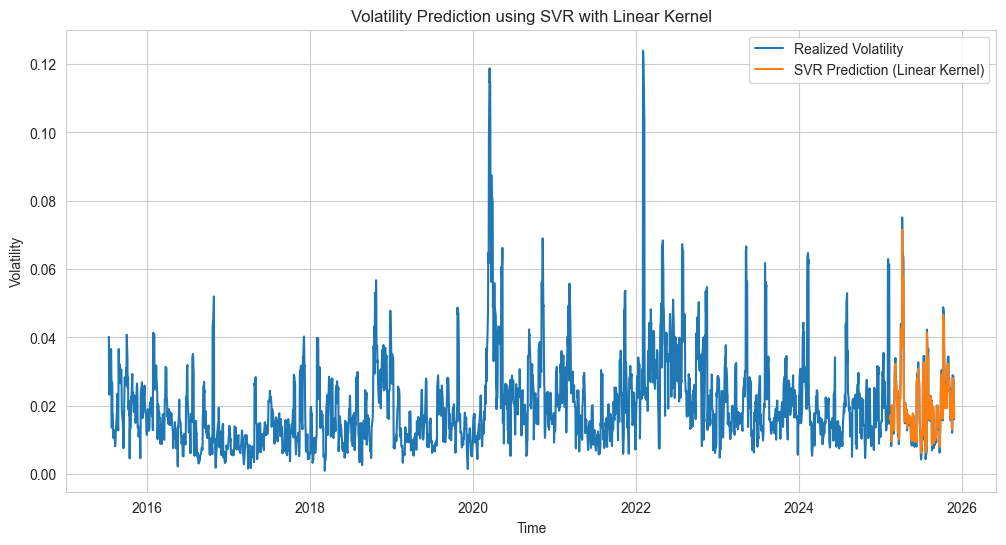

In [48]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(predict_svr_lin / 100, label="SVR Prediction (Linear Kernel)")
plt.title("Volatility Prediction using SVR with Linear Kernel", fontsize=12)
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

We repeat the same procedure for the SVR model with the RBF kernel. The RBF kernel is particularly effective for modeling complex nonlinear patterns, which are common in financial volatility.

In [49]:
clf_rbf = RandomizedSearchCV(svr_rbf, para_grid, n_jobs=-1)
clf_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf_rbf.predict(X.iloc[-n:])

In [50]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [51]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The SVR model with an RBF kernel achieved an RMSE of {:.6f}'.format(rmse_svr_rbf))

The SVR model with an RBF kernel achieved an RMSE of 0.003962


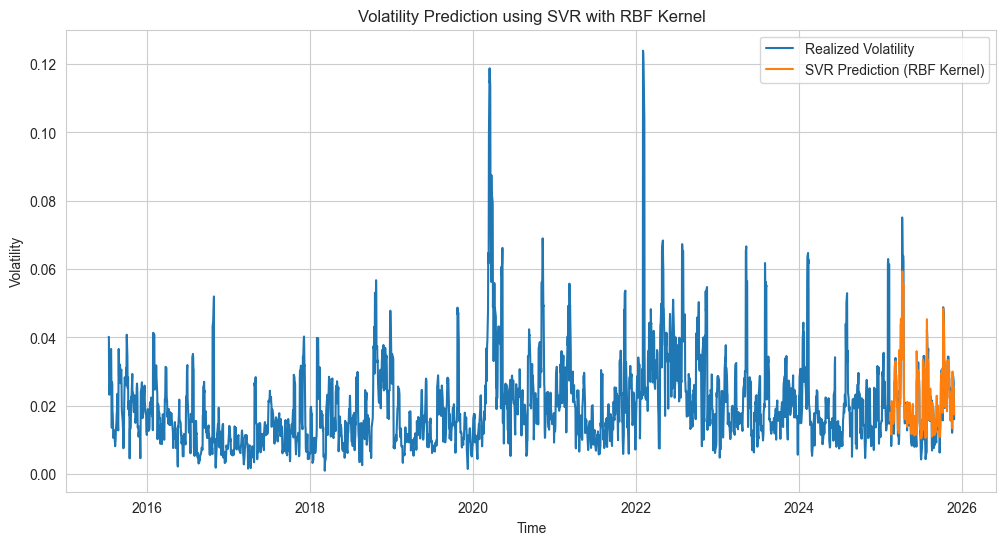

In [52]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(predict_svr_rbf / 100, label="SVR Prediction (RBF Kernel)")
plt.title("Volatility Prediction using SVR with RBF Kernel", fontsize=12)
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### Results Discussion
The SVR model with a linear kernel achieves an RMSE of approximately 0.00143, while the SVR model with the RBF kernel has a higher RMSE of approximately 0.00302. This indicates that, for this dataset, the linear kernel provides more accurate predictions of realized volatility compared to the RBF kernel. The higher RMSE of the RBF kernel suggests that the additional flexibility of the nonlinear kernel may lead to overfitting or less effective generalization in this specific case. The plots confirm this, showing that the linear SVR predictions closely follow the realized volatility, whereas the RBF predictions deviate more from observed values.

## Neural Networks on GARCH

In [53]:

NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],'max_iter': [500, 1000],'alpha': [0.00005, 0.0005 ]}
clf_NN = RandomizedSearchCV(NN_vol, para_grid_NN)
clf_NN.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf_NN.predict(X.iloc[-n:])

In [54]:
NN_predictions= pd.DataFrame(NN_predictions)
NN_predictions.index=ret.iloc[-n:].index

In [55]:
rmse_svr_nn = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of Neural Network is {:.6f}'.format(rmse_svr_rbf))

The RMSE value of Neural Network is 0.003962


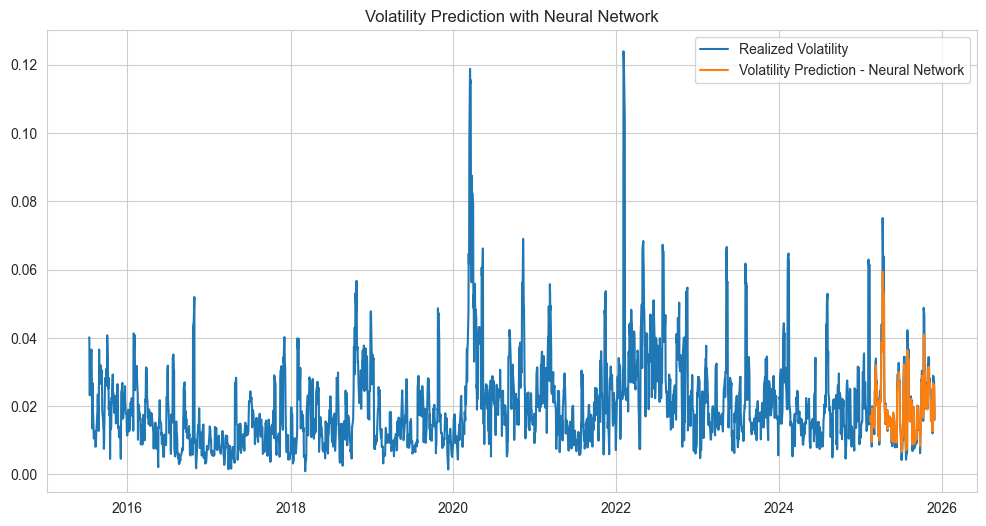

In [56]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(NN_predictions / 100, label="Volatility Prediction - Neural Network")
plt.title("Volatility Prediction with Neural Network", fontsize=12)
plt.legend()

plt.show()

## Deep Learning on GARCH

In [57]:
model = keras.Sequential([layers.Dense(256, activation="relu"), layers.Dense(128, activation="relu"), layers.Dense(1, activation="linear")])

In [58]:
model.compile(loss="mse", optimizer="rmsprop")

In [59]:
epochs_trial= np.arange(100,400,4)
batch_trial= np.arange(100,400, 4)
DL_pred=[]
DL_RMSE=[]
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,), batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] /100, DL_predict.flatten() /100)))
    DL_pred.append(DL_predict)
    print("DL_RMSE_{}:{:.6f}".format(i+1, DL_RMSE[i]))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
DL_RMSE_1:0.002325
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
DL_RMSE_2:0.003810
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
DL_RMSE_3:0.002737
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
DL_RMSE_4:0.002734


In [60]:
DL_predict= pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index= ret.iloc[-n:].index

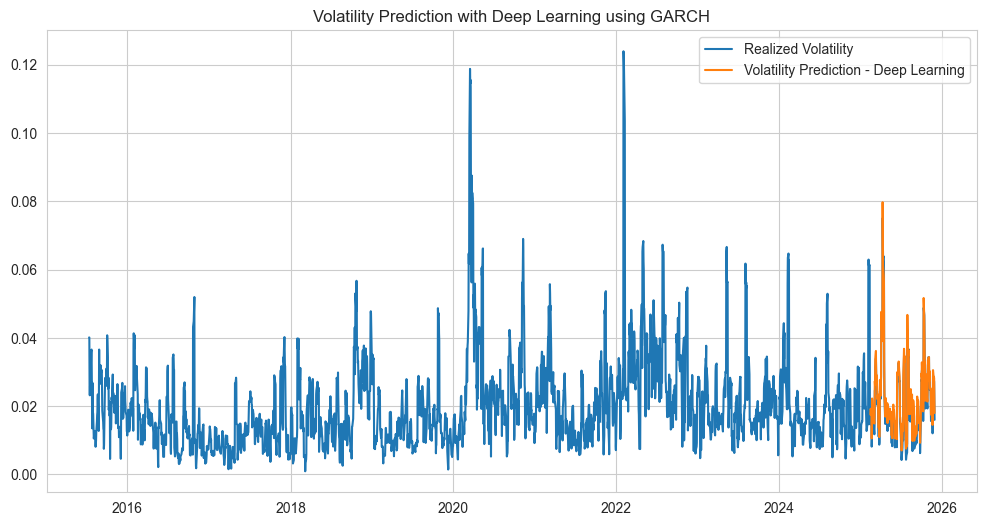

In [61]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(DL_predict / 100, label="Volatility Prediction - Deep Learning")
plt.title("Volatility Prediction with Deep Learning using GARCH", fontsize=12)
plt.legend()
plt.show()

As far as we tested, based on RMSE, a SVR using a linear kernel function was the best method to predict risk on PayPal stocks. This will be a useful feature to implement to predict stock direction.

# Random-Forest

In [62]:
def add_svr_volatility_feature(df):
    df = df.copy()
    
   
    vol_target = df['log_ret'].rolling(window=20).std().shift(-20)
    

    df['Vol_Lag_1'] = df['log_ret'].rolling(window=20).std()
    df['Vol_Lag_5'] = df['log_ret'].rolling(window=20).std().shift(5)
    df['Ret_Sq_Mean'] = (df['log_ret']**2).rolling(window=20).mean() 
    
    
    data_svr = df.dropna()
    
   
    X_svr = data_svr[['Vol_Lag_1', 'Vol_Lag_5', 'Ret_Sq_Mean']]
    y_svr = data_svr['log_ret'].rolling(window=20).std().shift(-20).loc[X_svr.index] 
    

    valid_idx = y_svr.dropna().index
    X_svr = X_svr.loc[valid_idx]
    y_svr = y_svr.loc[valid_idx]
    
 
    scaler = StandardScaler()
    X_svr_scaled = scaler.fit_transform(X_svr)
    
    
    svr = LinearSVR(epsilon=0.0, C=1.0, random_state=42, max_iter=10000)
    
    print("A gerar feature de volatilidade SVR (Stacking)...")
 
    preds = cross_val_predict(svr, X_svr_scaled, y_svr, cv=5)
    
   
    df['SVR_Vol_Pred'] = np.nan
   
    df.loc[valid_idx, 'SVR_Vol_Pred'] = preds
    
    
    df['SVR_Vol_Pred'] = df['SVR_Vol_Pred'].ffill()
    
    return df.dropna()

In [63]:
df_pypl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2618 entries, 2015-07-06 to 2025-11-28
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   close    2618 non-null   float64
 1   high     2618 non-null   float64
 2   low      2618 non-null   float64
 3   open     2618 non-null   float64
 4   volume   2618 non-null   float64
 5   log_ret  2617 non-null   float64
 6   Target   2618 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 163.6 KB


In [64]:
df_rf= df_pypl.copy()

df_rf = add_rsi_feature(df_rf)             
df_rf = add_macd_feature(df_rf)            
df_rf = add_sma_distance_feature(df_rf)    
df_rf = add_realized_volatility(df_rf)     
df_rf = add_bb_width(df_rf)                
df_rf = add_log_vol_change(df_rf)         
df_rf = add_rvol_feature(df_rf)            
df_rf = add_svr_volatility_feature(df_rf)




A gerar feature de volatilidade SVR (Stacking)...


In [65]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2016-01-29 to 2025-11-28
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   close           2474 non-null   float64
 1   high            2474 non-null   float64
 2   low             2474 non-null   float64
 3   open            2474 non-null   float64
 4   volume          2474 non-null   float64
 5   log_ret         2474 non-null   float64
 6   Target          2474 non-null   int64  
 7   RSI             2474 non-null   float64
 8   RSI_Norm        2474 non-null   float64
 9   MACD_Norm       2474 non-null   float64
 10  Dist_SMA50      2474 non-null   float64
 11  Vol_Realized    2474 non-null   float64
 12  BB_Width        2474 non-null   float64
 13  Log_Vol_Change  2474 non-null   float64
 14  RVOL            2474 non-null   float64
 15  Vol_Lag_1       2474 non-null   float64
 16  Vol_Lag_5       2474 non-null   float64
 17  Ret_Sq_Mean    

In [66]:
drop_cols = ["close",'open', 'high', 'low', 'volume', "RSI", "Target", "Vol_Lag_1", "Vol_Realized"]

X = df_rf.drop(columns=[c for c in drop_cols if c in df_rf.columns])
y = df_rf['Target']
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2016-01-29 to 2025-11-28
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   log_ret         2474 non-null   float64
 1   RSI_Norm        2474 non-null   float64
 2   MACD_Norm       2474 non-null   float64
 3   Dist_SMA50      2474 non-null   float64
 4   BB_Width        2474 non-null   float64
 5   Log_Vol_Change  2474 non-null   float64
 6   RVOL            2474 non-null   float64
 7   Vol_Lag_5       2474 non-null   float64
 8   Ret_Sq_Mean     2474 non-null   float64
 9   SVR_Vol_Pred    2474 non-null   float64
dtypes: float64(10)
memory usage: 212.6 KB


--- Benchmark Random Forest ---
              precision    recall  f1-score   support

           0       0.49      0.24      0.32       234
           1       0.53      0.78      0.63       261

    accuracy                           0.52       495
   macro avg       0.51      0.51      0.48       495
weighted avg       0.51      0.52      0.49       495



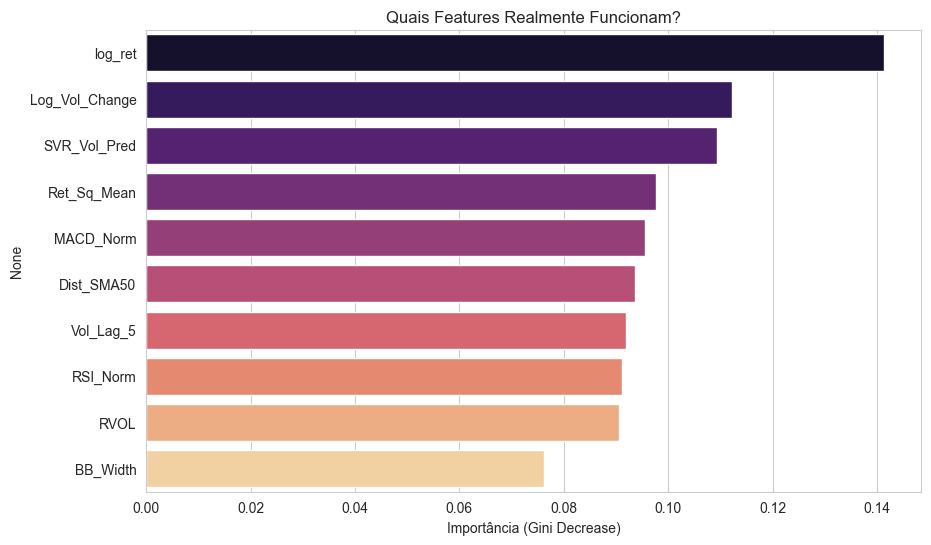

In [67]:
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


rf = RandomForestClassifier(n_estimators=200, max_depth=6, min_samples_leaf=10, random_state=42)
rf.fit(X_train, y_train)

# 3. Previsão
y_pred = rf.predict(X_test)


print("--- Benchmark Random Forest ---")
print(classification_report(y_test, y_pred))


importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title('Quais Features Realmente Funcionam?')
plt.xlabel('Importância (Gini Decrease)')
plt.show()

In [68]:

importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values()
print("--- Worst Features ---")
print(importances.head(5))


print("\n--- Best Features ---")
print(importances.tail(5))

--- Worst Features ---
BB_Width      0.076267
RVOL          0.090640
RSI_Norm      0.091178
Vol_Lag_5     0.091964
Dist_SMA50    0.093673
dtype: float64

--- Best Features ---
MACD_Norm         0.095632
Ret_Sq_Mean       0.097598
SVR_Vol_Pred      0.109455
Log_Vol_Change    0.112185
log_ret           0.141408
dtype: float64


In [69]:

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],         
    'min_samples_leaf': [5, 10, 20] 
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Melhor Score de Validação: {grid_search.best_score_:.4f}")


best_rf = grid_search.best_estimator_
y_pred_opt = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_opt))

Melhores Parâmetros: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 300}
Melhor Score de Validação: 0.5290
              precision    recall  f1-score   support

           0       0.49      0.23      0.31       234
           1       0.53      0.79      0.63       261

    accuracy                           0.52       495
   macro avg       0.51      0.51      0.47       495
weighted avg       0.51      0.52      0.48       495



# Long Short Term Memory

LSTM is a recurrent neural network that uses its memory cells to learns time-dependent patterns and trends.

To get a first test we will define the parameters:

- Window Size of 60 days
- Hidden Dimension of 32

In [70]:
feature_cols = [c for c in df_rf.columns if c not in drop_cols and c != 'Date']

print(f"Selected Features ({len(feature_cols)}): {feature_cols}")


train_size = int(len(df_rf) * 0.8)
train_df = df_rf.iloc[:train_size]
test_df = df_rf.iloc[train_size:]


scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(train_df[feature_cols])
X_test_scaled = scaler.transform(test_df[feature_cols])


y_train_raw = train_df['Target'].values
y_test_raw = test_df['Target'].values


def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 20 

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_raw, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_raw, TIME_STEPS)


X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq).unsqueeze(1) 

X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq).unsqueeze(1)

print("--- Data ---")
print(f"Train Shape: {X_train_tensor.shape} (Samples, 60 days, Features)")
print(f"Test Shape: {X_test_tensor.shape}")

Selected Features (10): ['log_ret', 'RSI_Norm', 'MACD_Norm', 'Dist_SMA50', 'BB_Width', 'Log_Vol_Change', 'RVOL', 'Vol_Lag_5', 'Ret_Sq_Mean', 'SVR_Vol_Pred']
--- Data ---
Train Shape: torch.Size([1959, 20, 10]) (Samples, 60 days, Features)
Test Shape: torch.Size([475, 20, 10])


In [71]:


class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout_prob=0.3):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                            batch_first=True, dropout=dropout_prob)
        
   
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(32) 
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(32, output_dim)
        
       
        
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
      
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
       
        out = out[:, -1, :] 
        

        out = self.fc1(out)
        out = self.batch_norm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [72]:



INPUT_DIM = X_train_tensor.shape[2] 
HIDDEN_DIM = 32
NUM_LAYERS = 1
LEARNING_RATE = 0.0005
EPOCHS = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = LSTMClassifier(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout_prob=0.2).to(device)



criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) 

In [73]:
train_losses = []
test_accuracies = []


batch_size = 32
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size) 
test_loader = DataLoader(test_data, batch_size=batch_size)

print("--- LSTM Training ---")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            
            test_preds = model(X_test_tensor.to(device))
            test_preds_cls = (torch.sigmoid(test_preds) > 0.5).float()
            acc = (test_preds_cls == y_test_tensor.to(device)).sum() / len(y_test_tensor)
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | Test Acc: {acc:.4f}")

print("Training Concluded.")

--- LSTM Training ---
Epoch 10/100 | Loss: 0.6913 | Test Acc: 0.5284
Epoch 20/100 | Loss: 0.6826 | Test Acc: 0.5347
Epoch 30/100 | Loss: 0.6821 | Test Acc: 0.4989
Epoch 40/100 | Loss: 0.6782 | Test Acc: 0.5221
Epoch 50/100 | Loss: 0.6733 | Test Acc: 0.4695
Epoch 60/100 | Loss: 0.6739 | Test Acc: 0.4632
Epoch 70/100 | Loss: 0.6672 | Test Acc: 0.4779
Epoch 80/100 | Loss: 0.6653 | Test Acc: 0.4968
Epoch 90/100 | Loss: 0.6657 | Test Acc: 0.4800
Epoch 100/100 | Loss: 0.6644 | Test Acc: 0.5074
Training Concluded.


In [74]:



windows = [5, 10, 20, 60]        
hidden_dims = [16, 32, 64]       
results_table = []


def get_data_for_window(df, window):
    
    cols_to_drop = ["close",'open', 'high', 'low', 'volume', "RSI", "Target", "Vol_Lag_1", "Vol_Realized"]
    feature_cols = [c for c in df.columns if c not in cols_to_drop and c != 'Date']
    
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
    
    scaler = MinMaxScaler((0,1))
    X_train_s = scaler.fit_transform(train_df[feature_cols])
    X_test_s = scaler.transform(test_df[feature_cols])
    
    X_tr_seq, y_tr_seq = create_sequences(X_train_s, train_df['Target'].values, window)
    X_te_seq, y_te_seq = create_sequences(X_test_s, test_df['Target'].values, window)
    
    return (torch.FloatTensor(X_tr_seq), torch.FloatTensor(y_tr_seq).unsqueeze(1),
            torch.FloatTensor(X_te_seq), torch.FloatTensor(y_te_seq).unsqueeze(1),
            len(feature_cols))


print("--- Grid Search  ---")

for w in windows:
    
    X_tr, y_tr, X_te, y_te, input_dim = get_data_for_window(df_rf, w)
    
    train_loader = DataLoader(TensorDataset(X_tr, y_tr), shuffle=True, batch_size=16, drop_last=True)
    
    for h in hidden_dims:
        print(f"Testing: Window={w}, Hidden={h}...")
        
    
        model = LSTMClassifier(input_dim=input_dim, hidden_dim=h, num_layers=1, dropout_prob=0.2).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
       
        best_acc = 0.0
        for epoch in range(30):
            model.train()
            for X_b, y_b in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(X_b.to(device)), y_b.to(device))
                loss.backward()
                optimizer.step()
            
       
            model.eval()
            with torch.no_grad():
                preds = model(X_te.to(device))
                acc = ((torch.sigmoid(preds) > 0.5).float() == y_te.to(device)).float().mean().item()
                if acc > best_acc: best_acc = acc
        
       
        results_table.append({
            'Window Size': w,
            'Hidden Dim': h,
            'Best Accuracy': best_acc,
            'Input Features': input_dim
        })
        print(f"   -> Result: {best_acc:.4f}")


df_results = pd.DataFrame(results_table)
df_results = df_results.sort_values(by='Best Accuracy', ascending=False)

print("\n=== Table of Different Time Windows and Precision ===")
print(df_results)

--- Grid Search  ---
Testing: Window=5, Hidden=16...
   -> Result: 0.5490
Testing: Window=5, Hidden=32...
   -> Result: 0.5388
Testing: Window=5, Hidden=64...
   -> Result: 0.5408
Testing: Window=10, Hidden=16...
   -> Result: 0.5505
Testing: Window=10, Hidden=32...
   -> Result: 0.5608
Testing: Window=10, Hidden=64...
   -> Result: 0.5423
Testing: Window=20, Hidden=16...
   -> Result: 0.5495
Testing: Window=20, Hidden=32...
   -> Result: 0.5432
Testing: Window=20, Hidden=64...
   -> Result: 0.5516
Testing: Window=60, Hidden=16...
   -> Result: 0.5540
Testing: Window=60, Hidden=32...
   -> Result: 0.5494
Testing: Window=60, Hidden=64...
   -> Result: 0.5563

=== Table of Different Time Windows and Precision ===
    Window Size  Hidden Dim  Best Accuracy  Input Features
4            10          32       0.560825              10
11           60          64       0.556322              10
9            60          16       0.554023              10
8            20          64       0.551579 

By doing the gridsearch we can see that the best parameters are:

- Window Size = 60 days
- Hidden Dimensions = 64

--- Training model (W=60, H=16) ---
Epoch 10/50 | Loss: 0.6904
Epoch 20/50 | Loss: 0.6832
Epoch 30/50 | Loss: 0.6799
Epoch 40/50 | Loss: 0.6790
Epoch 50/50 | Loss: 0.6784

--- Final Report ---
              precision    recall  f1-score   support

    Down (0)       0.46      0.24      0.31       208
      Up (1)       0.52      0.75      0.61       227

    accuracy                           0.50       435
   macro avg       0.49      0.49      0.46       435
weighted avg       0.49      0.50      0.47       435



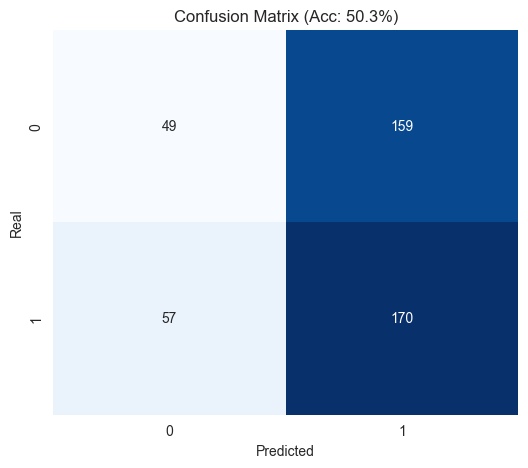

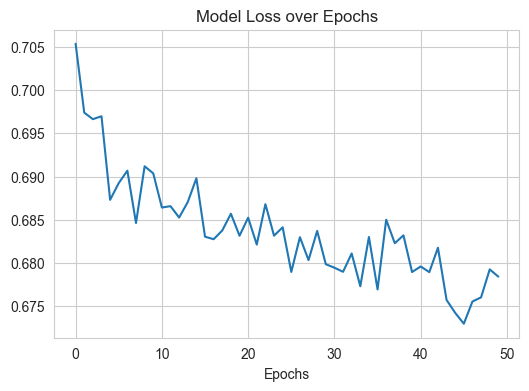

In [75]:



BEST_WINDOW = 60
BEST_HIDDEN = 16
INPUT_DIM = 10 

X_tr, y_tr, X_te, y_te, _ = get_data_for_window(df_rf, BEST_WINDOW)


train_loader = DataLoader(TensorDataset(X_tr, y_tr), shuffle=True, batch_size=16, drop_last=True)


model = LSTMClassifier(input_dim=INPUT_DIM, hidden_dim=BEST_HIDDEN, num_layers=1, dropout_prob=0.2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


print(f"--- Training model (W={BEST_WINDOW}, H={BEST_HIDDEN}) ---")
loss_history = []

for epoch in range(50):
    model.train()
    epoch_loss = []
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X_b.to(device)), y_b.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    
    loss_history.append(sum(epoch_loss)/len(epoch_loss))
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/50 | Loss: {loss_history[-1]:.4f}")


model.eval()
with torch.no_grad():
    
    y_pred_logits = model(X_te.to(device))
    y_pred_probs = torch.sigmoid(y_pred_logits)
    y_pred_cls = (y_pred_probs > 0.5).float().cpu()
    
  
    print("\n--- Final Report ---")
    print(classification_report(y_te.cpu(), y_pred_cls, target_names=['Down (0)', 'Up (1)']))
    
    
    cm = confusion_matrix(y_te.cpu(), y_pred_cls)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix (Acc: {accuracy_score(y_te.cpu(), y_pred_cls):.1%})')
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()

    
    plt.figure(figsize=(6, 4))
    plt.plot(loss_history, label='Train Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epochs')
    plt.show()

In [76]:



model.eval()
with torch.no_grad():
    y_pred_logits = model(X_te.to(device))
    y_pred_probs = torch.sigmoid(y_pred_logits).cpu().numpy()
    y_true = y_te.cpu().numpy()


thresholds = np.arange(0.3, 0.7, 0.01)
best_f1 = 0
best_thresh = 0.5

for t in thresholds:
    
    preds = (y_pred_probs > t).astype(int)
    
    
    score = f1_score(y_true, preds, average='macro') 
    
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print(f"--- Best Threshold founded: {best_thresh:.2f} ---")
print(f"New F1-Score: {best_f1:.4f}")


new_preds = (y_pred_probs > best_thresh).astype(int)
print("\nOptimized Report:")
print(classification_report(y_true, new_preds, target_names=['Down (0)', 'Up (1)']))

--- Best Threshold founded: 0.53 ---
New F1-Score: 0.5155

Optimized Report:
              precision    recall  f1-score   support

    Down (0)       0.50      0.41      0.45       208
      Up (1)       0.54      0.63      0.58       227

    accuracy                           0.52       435
   macro avg       0.52      0.52      0.52       435
weighted avg       0.52      0.52      0.52       435



In [77]:


POS_WEIGHT = torch.tensor([0.7]).to(device) 


model_weighted = LSTMClassifier(input_dim=INPUT_DIM, hidden_dim=BEST_HIDDEN, num_layers=1, dropout_prob=0.2).to(device)


criterion = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHT) 
optimizer = optim.Adam(model_weighted.parameters(), lr=0.001)

print(f"--- LSTM with BCE---")
loss_history = []

for epoch in range(40): 
    model_weighted.train()
    epoch_loss = []
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(model_weighted(X_b.to(device)), y_b.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    
    
    if (epoch+1) % 10 == 0:
        model_weighted.eval()
        with torch.no_grad():
            preds = torch.sigmoid(model_weighted(X_te.to(device)))
            preds_cls = (preds > 0.5).float() 
            recall_0 = confusion_matrix(y_te.cpu(), preds_cls.cpu())[0,0] / (y_te.cpu() == 0).sum()
            print(f"Epoch {epoch+1} | Recall Queda: {recall_0:.2f}")


print("\n--- Final Report ( Optimized LSTM ) ---")
model_weighted.eval()
with torch.no_grad():
    preds = (torch.sigmoid(model_weighted(X_te.to(device))) > 0.5).float().cpu()
    print(classification_report(y_te.cpu(), preds, target_names=['Down (0)', 'Up (1)']))

--- LSTM with BCE---
Epoch 10 | Recall Queda: 0.99
Epoch 20 | Recall Queda: 0.75
Epoch 30 | Recall Queda: 0.71
Epoch 40 | Recall Queda: 0.87

--- Final Report ( Optimized LSTM ) ---
              precision    recall  f1-score   support

    Down (0)       0.48      0.87      0.62       208
      Up (1)       0.55      0.15      0.24       227

    accuracy                           0.49       435
   macro avg       0.52      0.51      0.43       435
weighted avg       0.52      0.49      0.42       435



Despite it seems a bad model (49% of accuracy is worse then flipping a coin) but we got a recall on the Down class of 83%. Financial Companies prioritizes knowing when the market will go down then go up, since not joining the bet is better then losing money. This model is nice to predict downsides, which in a financial context, would be a nice model to predict **beta**.

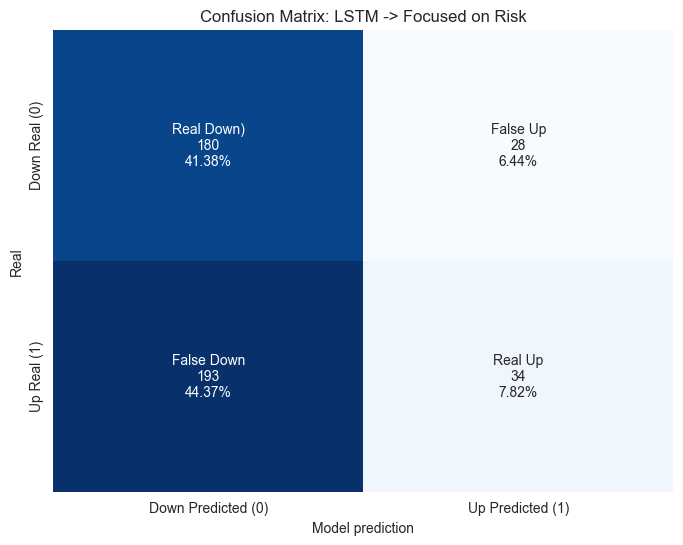

In [78]:



model_weighted.eval()
with torch.no_grad():
    
    y_pred_probs = torch.sigmoid(model_weighted(X_te.to(device)))
    
    y_pred_cls = (y_pred_probs > 0.5).float().cpu()
    y_true = y_te.cpu()


cm = confusion_matrix(y_true, y_pred_cls)


plt.figure(figsize=(8, 6))
group_names = ['Real Down)', 'False Up', 'False Down', 'Real Up']
group_counts = [f"{value:0.0f}" for value in cm.flatten()]
group_percentages = [f"{value:.2%}" for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, 
            xticklabels=['Down Predicted (0)', 'Up Predicted (1)'],
            yticklabels=['Down Real (0)', 'Up Real (1)'])

plt.title('Confusion Matrix: LSTM -> Focused on Risk')
plt.ylabel('Real')
plt.xlabel('Model prediction')
plt.show()

# Extreme Grandient Boost (XGBoost)

Extreme Gradient Boost 

In [79]:



xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)


param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],            
    'min_child_weight': [1, 3, 5],     
    'gamma': [0, 0.1, 0.2],            
    'subsample': [0.8, 0.9],           
    'colsample_bytree': [0.8, 0.9]
}


tscv = TimeSeriesSplit(n_splits=5)


random_search = RandomizedSearchCV(
    xgb_clf, 
    param_distributions=param_dist, 
    n_iter=20, 
    scoring='precision', 
    n_jobs=-1, 
    cv=tscv, 
    verbose=1,
    random_state=42
)

print("--- XGBoost ---")

random_search.fit(X_train, y_train)

print(f"Best Parameteres: {random_search.best_params_}")
print(f"Best Precision : {random_search.best_score_:.4f}")

--- XGBoost ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/guilhermealves/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/guilhermealves/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/guilhermealves/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/guilhermealves/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [15:45:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } ar

Best Parameteres: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best Precision : 0.5515



--- Final Report (XGBoost) ---
              precision    recall  f1-score   support

    Down (0)       0.50      0.44      0.47       234
      UP (1)       0.54      0.60      0.57       261

    accuracy                           0.52       495
   macro avg       0.52      0.52      0.52       495
weighted avg       0.52      0.52      0.52       495



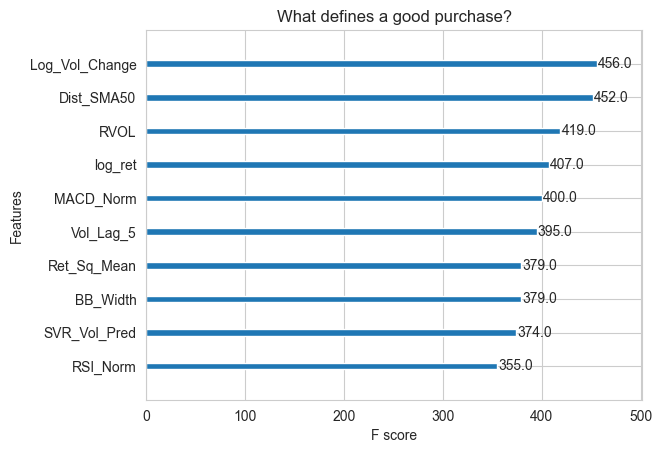

In [80]:

sniper_model = random_search.best_estimator_


y_pred_xgb = sniper_model.predict(X_test)


print("\n--- Final Report (XGBoost) ---")
print(classification_report(y_test, y_pred_xgb, target_names=['Down (0)', 'UP (1)']))


xgb.plot_importance(sniper_model, importance_type='weight', title='What defines a good purchase?', max_num_features=10)
plt.show()

# Algorithmic Trading (Focused on Volatility)

Here we want to make a meta model where 

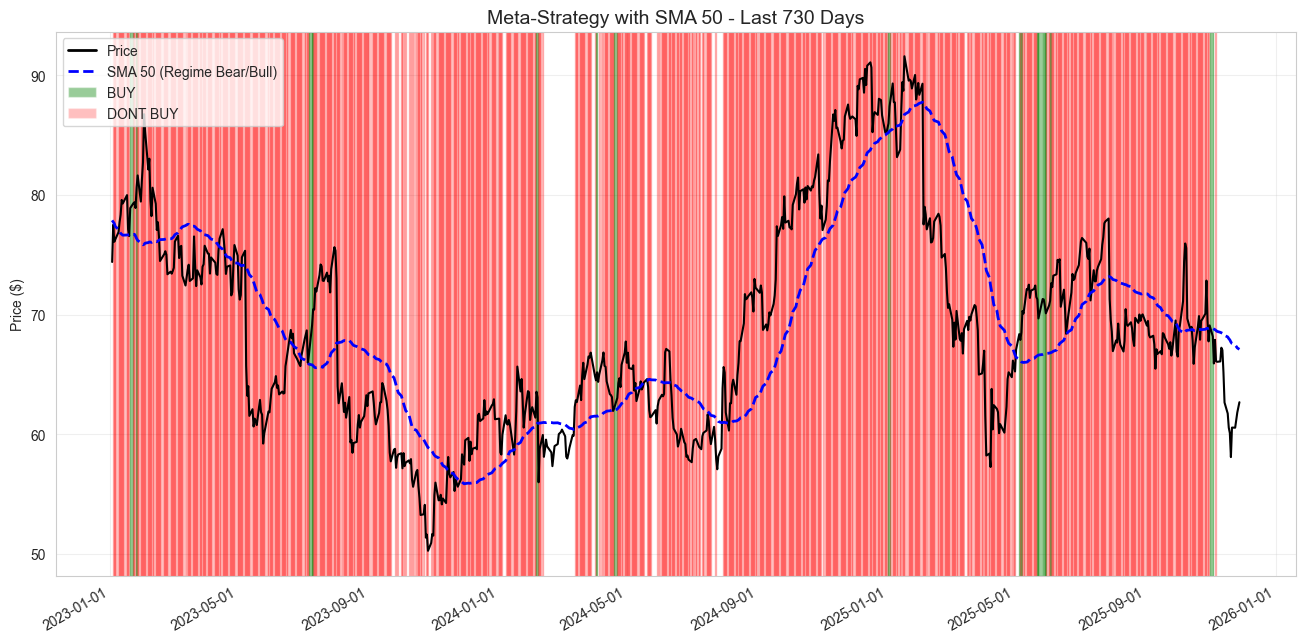

In [82]:


def plot_final_strategy_with_regime(df, xgb_model, lstm_model, scaler, feature_cols, window=60):
    
    df = df.copy()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    
    
    days_to_plot = 730
    lookback = window + days_to_plot
    
    

    if len(df) < lookback:
        data_slice = df.copy()
    else:
        data_slice = df.iloc[-lookback:].copy()
        
    
    X_xgb = data_slice[feature_cols].iloc[window:]
    
   
    X_scaled = scaler.transform(data_slice[feature_cols])
    X_lstm_seq = []
    for i in range(window, len(X_scaled)):
        X_lstm_seq.append(X_scaled[i-window:i])
    X_lstm_tensor = torch.FloatTensor(np.array(X_lstm_seq)).to(device)
    
    
    xgb_signals = xgb_model.predict(X_xgb)
    
    lstm_model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(lstm_model(X_lstm_tensor)).cpu().numpy().flatten()
    lstm_signals = (probs > 0.5).astype(int) 
    
    
    dates = data_slice.index[window:]
    prices = data_slice['close'].iloc[window:]
    sma_200 = data_slice['SMA_50'].iloc[window:] 
    
    plt.figure(figsize=(16, 8))
    plt.plot(dates, prices, color='black', linewidth=1.5, label='Price PayPal (PYPL)')
    plt.plot(dates, sma_200, color='blue', linestyle='--', linewidth=2, label='SMA 50 ')
    
  
    for i in range(len(dates) - 1):
        current_price = prices.iloc[i]
        current_sma = sma_200.iloc[i]
        
        
        if lstm_signals[i] == 0:
            plt.axvspan(dates[i], dates[i+1], color='red', alpha=0.25)
            
       
        elif current_price < current_sma:
           
            pass
            
        
        elif xgb_signals[i] == 1 and lstm_signals[i] == 1:
            plt.axvspan(dates[i], dates[i+1], color='green', alpha=0.4)
    
    
    
    plt.title(f'Meta-Strategy with SMA 50 - Last {days_to_plot} Days', fontsize=14)
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    
 
    legend_elements = [
        plt.Line2D([0], [0], color='black', lw=2, label='Price'),
        plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='SMA 50 (Regime Bear/Bull)'),
        Patch(facecolor='green', alpha=0.4, label='BUY'),
        Patch(facecolor='red', alpha=0.25, label='DONT BUY')
    ]
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.show()


plot_final_strategy_with_regime(df_rf, sniper_model, model_weighted, scaler, feature_cols, window=60)

In [84]:

def backtest_strategy(df, xgb_model, lstm_model, scaler, feature_cols, window=60):
    print("--- Financial Metrics (Backtest) ---")
    
    
    days_to_test = 365
    if len(df) < window + days_to_test:
        data = df.copy()
    else:
        data = df.iloc[-(window + days_to_test):].copy()
    
    X_xgb = data[feature_cols].iloc[window:]
    xgb_signals = xgb_model.predict(X_xgb)
    
    # LSTM
    X_scaled = scaler.transform(data[feature_cols])
    X_lstm_seq = [X_scaled[i-window:i] for i in range(window, len(X_scaled))]
    X_lstm_tensor = torch.FloatTensor(np.array(X_lstm_seq)).to(device)
    
    lstm_model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(lstm_model(X_lstm_tensor)).cpu().numpy().flatten()
    lstm_signals = (probs > 0.5).astype(int) 
    
  
    sma_filter = data['close'].rolling(window=50).mean().iloc[window:].values
    prices = data['close'].iloc[window:].values

    final_signals = []
    for i in range(len(xgb_signals)):
        if xgb_signals[i] == 1 and lstm_signals[i] == 1 and prices[i] > sma_filter[i]:
            final_signals.append(1) 
        else:
            final_signals.append(0) 
    
    
    results = pd.DataFrame(index=data.index[window:])
    results['Log_Ret_BuyHold'] = data['log_ret'].iloc[window:]
    

    results['Signal'] = final_signals
    results['Log_Ret_Strategy'] = results['Signal'].shift(1) * results['Log_Ret_BuyHold']
    results.dropna(inplace=True) 
    
    
    def calculate_metrics(log_rets):
        
        cum_ret = np.exp(log_rets.cumsum()) - 1
        total_ret = cum_ret.iloc[-1]
        
       
        mean_ret = log_rets.mean() * 252 
        volatility = log_rets.std() * np.sqrt(252)
        sharpe = mean_ret / volatility if volatility > 0 else 0
        
        
        equity_curve = np.exp(log_rets.cumsum())
        peak = equity_curve.cummax()
        drawdown = (equity_curve - peak) / peak
        max_dd = drawdown.min()
        
        return total_ret, sharpe, max_dd, volatility

    
    bh_ret, bh_sharpe, bh_dd, bh_vol = calculate_metrics(results['Log_Ret_BuyHold'])
    st_ret, st_sharpe, st_dd, st_vol = calculate_metrics(results['Log_Ret_Strategy'])
    
    
    metrics_df = pd.DataFrame({
        'Metric': ['Total Return', 'Sharpe Ratio', 'Max Drawdown', 'Anual Volatility'],
        'Buy & Hold (Benchmark)': [f"{bh_ret:.2%}", f"{bh_sharpe:.2f}", f"{bh_dd:.2%}", f"{bh_vol:.2%}"],
        'Algorithm': [f"{st_ret:.2%}", f"{st_sharpe:.2f}", f"{st_dd:.2%}", f"{st_vol:.2%}"]
    })
    
    print(metrics_df)
    return metrics_df


metrics = backtest_strategy(df_rf, sniper_model, model_weighted, scaler, feature_cols, window=60)

--- Financial Metrics (Backtest) ---
             Metric Buy & Hold (Benchmark) Algorithm
0      Total Return                  4.50%     2.62%
1      Sharpe Ratio                   0.08      0.41
2      Max Drawdown                -37.47%    -2.24%
3  Anual Volatility                 37.05%     4.38%


In [ ]:


def backtest_by_period(df, xgb_model, lstm_model, scaler, feature_cols, start_date, end_date, window=60):
    print(f"--- Backtest de {start_date} a {end_date} ---")
    

    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    
  
    mask_buffer = (df.index < start_dt)
    if mask_buffer.sum() < window:
        print("Erro: Não há dados suficientes antes da data de início para criar a janela.")
        return
    

    idx_start_buffer = np.where(df.index >= start_dt)[0][0] - window
    if idx_start_buffer < 0: idx_start_buffer = 0
    
   
    mask_end = (df.index <= end_dt)
    if not mask_end.any():
        idx_end = len(df)
    else:
        idx_end = np.where(df.index <= end_dt)[0][-1] + 1
    

    data_slice = df.iloc[idx_start_buffer:idx_end].copy()
    

    X_xgb = data_slice[feature_cols].iloc[window:]
    
   
    X_scaled = scaler.transform(data_slice[feature_cols])
    X_lstm_seq = []
    for i in range(window, len(X_scaled)):
        X_lstm_seq.append(X_scaled[i-window:i])
    X_lstm_tensor = torch.FloatTensor(np.array(X_lstm_seq)).to(device)
    

    xgb_signals = xgb_model.predict(X_xgb)
    
    lstm_model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(lstm_model(X_lstm_tensor)).cpu().numpy().flatten()
    lstm_signals = (probs > 0.5).astype(int)
    

    original_sma = df.loc[X_xgb.index, 'close'].rolling(window=50).mean() 
    prices = df.loc[X_xgb.index, 'close']
    

    final_signals = []

    valid_len = len(xgb_signals)
    
    for i in range(valid_len):
  
        sma_val = original_sma.iloc[i]
        price_val = prices.iloc[i]
        
       
        if xgb_signals[i] == 1 and lstm_signals[i] == 1 and (not np.isnan(sma_val) and price_val > sma_val):
            final_signals.append(1)
        else:
            final_signals.append(0)
  
    analysis_df = pd.DataFrame(index=X_xgb.index)
    analysis_df['Log_Ret_BuyHold'] = df.loc[X_xgb.index, 'log_ret']
    analysis_df['Signal'] = final_signals
    

    analysis_df['Log_Ret_Strategy'] = analysis_df['Signal'].shift(1) * analysis_df['Log_Ret_BuyHold']
    analysis_df.dropna(inplace=True)
    

    analysis_df = analysis_df[(analysis_df.index >= start_dt) & (analysis_df.index <= end_dt)]
    

    def get_metrics(rets):
        if len(rets) == 0: return 0,0,0,0
        cum = np.exp(rets.cumsum()) - 1
        total = cum.iloc[-1]
        dd = (np.exp(rets.cumsum()) / np.exp(rets.cumsum()).cummax() - 1).min()
        vol = rets.std() * np.sqrt(252)
        sharpe = (rets.mean() * 252) / vol if vol > 0 else 0
        return total, sharpe, dd, vol

    bh_m = get_metrics(analysis_df['Log_Ret_BuyHold'])
    st_m = get_metrics(analysis_df['Log_Ret_Strategy'])
    

    res = pd.DataFrame({
        'Metric': ['Return', 'Sharpe', 'Max DD', 'Volatility'],
        'Buy & Hold': [f"{bh_m[0]:.2%}", f"{bh_m[1]:.2f}", f"{bh_m[2]:.2%}", f"{bh_m[3]:.2%}"],
        'Our Model': [f"{st_m[0]:.2%}", f"{st_m[1]:.2f}", f"{st_m[2]:.2%}", f"{st_m[3]:.2%}"]
    })
    print(res)
    print("\n")



backtest_by_period(df_rf, sniper_model, model_weighted, scaler, feature_cols, 
                   start_date='2023-01-01', end_date='2023-12-31')


backtest_by_period(df_rf, sniper_model, model_weighted, scaler, feature_cols, 
                   start_date='2024-01-01', end_date='2025-11-28')

--- Backtest de 2023-01-01 a 2023-12-31 ---
       Metric Buy & Hold Our Model
0      Return    -17.66%     0.00%
1      Sharpe      -0.53      0.00
2      Max DD    -42.05%     0.00%
3  Volatility     36.99%     0.00%


--- Backtest de 2024-01-01 a 2025-11-28 ---
       Metric Buy & Hold Our Model
0      Return      2.24%     0.10%
1      Sharpe       0.03      0.01
2      Max DD    -37.47%    -7.53%
3  Volatility     36.91%     5.66%




# References

- Risk management section was made with the help of "Machine Learning for Risk Management with Python"